In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import re
import os
import sentencepiece as spm
import pickle
import pathlib
from fastai.text import *
torch.cuda.set_device(0)

working_path = '/kaggle/working'
input_data_path = '/kaggle/input'

data_paths = {}
for dirname, _, filenames in os.walk(input_data_path):
    for filename in filenames:
        data_paths[filename] = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

/kaggle/input/telugu-wikipedia-data/telugu_wiki_links.csv
/kaggle/input/telugu-wikipedia-data/telugu_wikipedia_dataset.parquet
/kaggle/input/telugu-sentencepiece-tokenizer/__notebook__.ipynb
/kaggle/input/telugu-sentencepiece-tokenizer/__results__.html
/kaggle/input/telugu-sentencepiece-tokenizer/__output__.json
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.model
/kaggle/input/telugu-sentencepiece-tokenizer/custom.css
/kaggle/input/telugu-sentencepiece-tokenizer/telugu_tok.vocab
/kaggle/input/telugu-sentencepiece-tokenizer/TeluguWikiSentences.txt


In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.59', '1.3.0')

In [3]:
tel_df = pd.read_parquet(data_paths['telugu_wikipedia_dataset.parquet'])
tel_df.shape, tel_df.columns

((99052, 2), Index(['title', 'text'], dtype='object'))

In [4]:
texts = (tel_df['title'] + ' ' + tel_df['text']).tolist()
texts = [t for t in tel_df['text'] if len(t.strip())>1]
print(len(texts))

94435


In [5]:
df = pd.DataFrame(texts, columns = ['text'])

In [6]:
del tel_df, texts
gc.collect()

47

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.shape, test_df.shape

((75548, 1), (18887, 1))

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load(data_paths['telugu_tok.model'])
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [9]:
from telugu_tokenizer_class_fastai import TeluguTokenizer
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [10]:
data_lm = TextLMDataBunch.from_df(working_path, train_df=train_df, valid_df=test_df,
                                  text_cols=["text"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_lm.data')

In [11]:
data_lm.show_batch()

idx,text
0,"▁సంఖ్య ▁10 ▁కాగా ▁షెడ్యూల్డ్ ▁తెగల ▁సంఖ్య ▁0. ▁గ్రామం ▁యొక్క ▁జనగణన ▁లొకేషన్ ▁కోడ్ ▁58 02 66 [1]. పిన్ ▁కోడ్ : ▁532 22 1. ▁ఒక ▁సంచార ▁వైద్య ▁శాలలో ▁డాక్టర్లు ▁లేరు . ▁ముగ్గురు ▁పారామెడికల్ ▁సిబ్బంది ▁ఉన్నారు . ▁ప్రాథమిక ▁ఆరోగ్య ▁కేంద్రం , ▁ప్రాథమిక ▁ఆరోగ్య ▁ఉప ▁కేంద్రం ▁గ్రామం ▁నుండి ▁5 ▁నుండి ▁10 ▁కి . మీ . ▁దూరంలో ▁ఉన్నాయి . ▁అలోపతి ▁ఆసుపత్రి , ▁డిస్పెన్సరీ , ▁పశు ▁వైద్యశాల , ▁కుటుంబ ▁సంక్షేమ ▁కేంద్రం ▁గ్రామం ▁నుండి ▁5 ▁నుండి ▁10"
1,"▁చూపింది , ▁యు . స్ . ▁సుప్రీం ▁కోర్ట్ ▁ఉద్యోగం ▁ఇవ్వ టానికి <unk> ▁i q ▁పరీక్షల ▁వాడకాన్ని ▁కొన్ని ▁అరుదైన ▁సందర్భాలలో ▁తప్ప ▁మిగిలిన వాటి కి ▁నిషేధించారు [84] . ▁అంతర్జాతీయంగా , ▁కొన్ని ▁ప్రజా ▁విధానాలు , ▁పోషక పదార్ధాల ను ▁మెరుగుపరచ టం ▁మరియు ▁to x ins ▁లాంటివి ▁ఉన్నాయి , ▁వారి ▁లక్ష్యాల లో ▁ఒకటి ▁ప్రజ్ఞ ను ▁పెంచ టం ▁లేదా ▁తరుగుదల ను ▁ఆప టం ▁ఉంది . ▁ఫ్రెంచ్ ▁మనస్తత్వ శాస్త్ర ▁నిపుణుడు ▁అల్ ఫ్ రెడ్ ▁బి నెట్ <unk> ▁i"
2,"▁8 ▁ఉన్నాయి . ▁ఒక ▁ప్రభుత్వ ▁జూనియర్ ▁కళాశాల , ▁3 ▁ప్రైవేటు ▁జూనియర్ ▁కళాశాలలు ▁ఒక ▁ప్రభుత్వ ▁ఆర్ట్స్ ▁/ ▁సైన్స్ ▁డిగ్రీ ▁కళాశాల , ▁ఒక ▁ప్రైవేటు ▁ఆర్ట్స్ ▁/ ▁సైన్స్ ▁డిగ్రీ ▁కళాశాల ▁ఉన్నాయి . ▁గ్రామంలో ▁ఒక ▁ప్రైవేటు ▁మేనేజిమెంటు ▁కళాశాల ▁ఉంది . ▁ఒక ▁ప్రభుత్వ ▁పాలీటెక్నిక్ ▁ఉంది . ▁ఒక ▁ప్రైవేటు ▁వృత్తి ▁విద్యా ▁శిక్షణ ▁పాఠశాల ▁ఉంది . ▁సమీప ▁ఇంజనీరింగ్ ▁కళాశాల ▁ఒంగోలు లో ▁ఉంది . ▁సమీప ▁వైద్య ▁కళాశాల ▁గుంటూరులో ▁ఉంది . ▁సమీప ▁అనియత ▁విద్యా ▁కేంద్రం , ▁బ ధి రు"
3,▁భౌతిక ▁శాస్త్రము ▁· ▁రసాయన ▁శాస్త్రము ▁· ▁ఖగోళ ▁శాస్త్రము ▁· ▁గణిత ము ▁· ▁కంప్యూటరు ▁భాష ▁· ▁కులాల ు ▁· ▁తెగలు ▁· ▁మతాలు ▁· ▁ప్రాచీన ▁నాగరికత లు ▁· ▁రాజకీయ ం ▁· ▁ప్రజా ▁ఉద్యమాలు ▁· ▁విద్య ▁· ▁వృత్తులు ▁· ▁సామాజిక ▁సిద్ధాంతాలు ▁పుణ్యక్షేత్రాల ు ▁· ▁దర్శన ీయ ▁స్థలాలు ▁· ▁జిల్లాలు ▁· ▁మండలాలు ▁· ▁గ్రామాలు ▁· ▁నదులు ▁· ▁జానపద ▁కళారూపాల ు ▁· ▁చరిత్ర ▁· ▁తెలంగాణ ▁వ్యక్తులు ▁దేశాలు ▁· ▁వారసత్వ ▁ప్రదేశాలు ▁· ▁ప్రపంచ ▁ప్రసిద్ధ ులు ▁·
4,▁స పో ట ▁పండు ను ▁పోలి వుండును . ▁పండిన ప్పుడు ▁పాలి ఫొ యిన ▁బ్రౌన్ ▁రంగులో ▁వుండును . ఒక ▁చెట్టు నుండి ▁ఏడాది కి ▁400 - 500 ▁కీ జి . ల వరకు ▁పళ్ళు వు త్పత్తి ▁అగును . పండు లో ▁గింజ శాతం ▁4 7% ▁వుండును . గింజ లో ▁నూనె ▁/ ▁కొవ్వు ▁19 -2 3% ▁వరకు ండును . ▁పచ్చి గా వున్న ▁గింజల ్లో ▁తేమ శాతం ▁ఎక్కువ ▁వుండును . ▁గింజల ను ▁ఆర బెట్టి న ▁(


In [12]:
len(data_lm.vocab.itos)

25000

In [13]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25)
learn = learn.to_fp16(clip=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


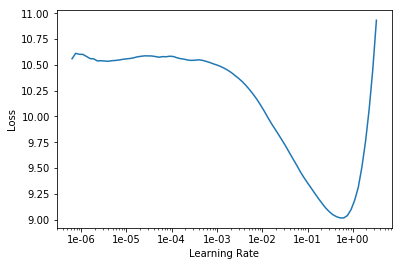

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save('first', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time


In [16]:
learn.load('first', with_opt=True);

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2, moms=(0.8,0.7))
learn.save('second', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.770269,3.837296,0.408489,30:30
1,3.812927,3.707463,0.419479,30:29
2,3.458133,3.453252,0.443968,30:31
3,3.190268,3.151143,0.479116,30:31


In [18]:
learn.load('second', with_opt=True);

In [19]:
# learn.lr_find()
# learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))
learn.save('third', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.041175,3.023907,0.497605,30:31
1,2.947432,3.002214,0.501123,30:31
2,2.901387,2.959659,0.507665,30:30
3,2.889405,2.917361,0.514284,30:30


In [21]:
learn.load('third', with_opt=True);

In [22]:
learn.fit_one_cycle(5, 1e-4, moms=(0.8,0.7))
learn.save('fourth', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,2.819849,2.906512,0.516240,30:32
1,2.971144,2.902586,0.516919,30:31
2,2.722646,2.898757,0.517735,30:31
3,2.888450,2.895185,0.518327,30:32


In [23]:
learn.load('fourth', with_opt=True);

In [24]:
TEXT = "ఇది మండల కేంద్రమైన రంపచోడవరం నుండి"
N_WORDS = 20
N_SENTENCES = 2

In [25]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁10 ▁కి . ▁మీ . ▁దూరంలో ▁ఉంది . ▁2011 ▁భారత ▁జనగణన ▁గణాంకాల ▁ప్రకారం ▁ఈ ▁గ్రామం ▁2 85 ▁ఇళ్లతో , ▁7
ఇది మండల కేంద్రమైన రంపచోడవరం నుండి ▁5 ▁కి . ▁మీ . ▁దూరం ▁లోను , ▁సమీప ▁పట్టణమైన ▁రాజమహేంద్రవరం ▁నుండి ▁54 ▁కి . ▁మీ . ▁దూరంలోనూ ▁ఉంది .


### Extract embeddings

In [26]:
defaults.device = torch.device('cpu')
learn.model.eval()
learn.export()

In [27]:
# Generating embedding vectors for visualization

In [28]:
telugu_lm_path = os.path.join(working_path)

In [29]:
!rm -rf models\

In [30]:
!ls

__notebook__.ipynb  __output__.json  export.pkl  models  telugu_lm.data


In [31]:
learn = load_learner(working_path)

In [32]:
encoder = get_model(learn.model)[0]
encoder.state_dict()['encoder.weight'].shape

torch.Size([25000, 400])

In [33]:
embeddings = encoder.state_dict()['encoder.weight']
embeddings = np.array(embeddings)
embeddings[0].shape

(400,)

In [34]:
df1 = pd.DataFrame(embeddings)
df1.shape

(25000, 400)

In [35]:
df1.index = itos

In [36]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
<unk>,0.033508,-0.498047,0.052155,0.076111,-0.109070,-0.419434,-0.423096,-0.906250,0.255859,0.024567,...,0.006126,0.132324,-0.127075,0.085022,0.118164,-0.517578,-0.308838,-0.109070,0.064819,0.275391
<s>,0.029022,-0.080444,0.018326,0.002062,-0.149780,-0.038666,-0.079590,-0.228394,0.162109,0.166382,...,0.125488,-0.074646,-0.074768,0.086609,0.083923,-0.805176,-0.387695,-0.140747,0.143677,0.050018
</s>,0.029022,-0.080444,0.018326,0.002062,-0.149780,-0.038666,-0.079590,-0.228394,0.162109,0.166382,...,0.125488,-0.074646,-0.074768,0.086609,0.083923,-0.805176,-0.387695,-0.140747,0.143677,0.050018
.,0.435791,-0.795410,-0.090942,0.468506,-0.099426,-0.093018,-0.071045,-0.505859,0.813965,0.096252,...,0.080994,0.572266,-0.108826,0.031738,0.068115,-0.408691,-0.579102,-0.247559,0.231323,0.189697
",",0.075378,-0.594727,0.108521,0.096985,-0.294189,-0.084534,-0.066284,-0.394287,0.268311,0.135620,...,0.017410,0.421631,-0.127197,-0.021179,0.344238,-0.576660,-0.520508,0.031021,0.211670,0.397949


In [37]:
df1.to_csv('embedding_vectors.tsv', sep='\t', index = False, header=False)

In [38]:
df2 = pd.DataFrame(itos)
df2.shape

(25000, 1)

In [39]:
df2.head()

,0
0,<unk>
1,<s>
2,</s>
3,.
4,","


In [40]:
df2.to_csv('embeddings_metadata.tsv', sep='\t', index=False, header=False)

In [41]:
### 